## This notebook loads in the raw database scrape from previous notebook. The data is then parsed and tokenized and stored in a CSV for training models


In [2]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
%cd ..

/home/glect/pytorch/yaamformer


### Read in the scraped database file

In [3]:
with open('./data/orf.data', 'rb') as filehandle:
    # read the data as binary data stream
    yaamScrape = pickle.load(filehandle)

### Collect the sequence and PTMs for each ORF

In [4]:
#PTM types
ptm_dict = {'Ca': 1,
 'Methylation': 2,
 'NtAcetylation': 3,
 'Ubiquitination': 4,
 'Disulfide': 5,
 'Phosphorylation': 6,
 'Succinylation': 7,
 'Biotinylation': 8,
 'Oxidation': 9,
 'Nitration': 10,
 'Metal': 11,
 'Lipidation': 12,
 'ActiveSite': 13,
 'Glycosylation': 14,
 'Acetylation': 15,
 'Sumoylation': 16}


In [78]:
def collect_ptms(orf_data):
    """
    parses the data collected from YAAM database
    """
    
    #set up tracking dictionary
    ptm_dict_store ={} #contains all positions of PTM and their types
    for ptm_id in ptm_dict.values():
        ptm_dict_store[ptm_id] = []

    total_ptm = 0
    total_residue = 0

    for i in orf_data:
        total_ptm += 1
        total_residue +=1
        #print(i)
        #collect the position/type for each present PTM in the ORF

        #single modification present -> simple
        if i['modification'].count(',') == 0:
            PTM_TOKEN = ptm_dict[i['modification']]
            ptm_dict_store[PTM_TOKEN].append(i['position'])
        #multiple modifications -> add steps
        else:
            mods = i['modification'].split(',')
            for x in mods:
                x = x.rstrip().lstrip() #bad white space present
                #print(x)
                total_residue +=1
                PTM_TOKEN = ptm_dict[x]
                ptm_dict_store[PTM_TOKEN].append(i['position'])
             
    #collect which residues have PTMs
    all_locations = []
    #print(ptm_dict_store.values())
    for i in ptm_dict_store.values():
        for x in i:
            all_locations.append(x)
    all_locations = list(set(all_locations)) #remove duplicates
    

    return all_locations, total_ptm

In [ ]:
yaamScrape

In [82]:
yaamScrape[110]

{'orf': 'YGL077C',
 'seq': {"data":[{"systematic_name":"YGL077C","location":"plasma membrane","sequence":"MSIRNDNASGGYMQPDQSSNASMHKRDLRVEEEIKPLDDMDSKGAVAADGEVHLRKSFSLWSILGVGFGLTNSWFGISTSMVAGISSGGPMMIVYGIIIVALISICIGTSLGELSSAYPHAGGQFWWSLKLAPPKYKRFAAYMCGSFAYAGSVFTSASTTLSVATEVVGMYALTHPEFIPKRWHIFVCFELLHLFLMFFNCYGKSLPIISSSSLYISLLSFFTITITVLACSHGKFNDAKFVFATFNNETGWKNGGIAFIVGLINPAWSFSCLDCATHMAFEVEKPERVIPIAIMGTVAIGFVTSFCYVIAMFFSIQDLDAVLSSTTGAPILDIYNQALGNKSGAIFLGCLILFTSFGCVIACHTWQARLCWSFARDNGLPLSRLWSQVNPHTGVPLNAHLMSCAWITLIGLLYLASSTAFQSLITGCIAFLLLSYIIPVICLLAKKRNIAHGPFWLGKFGFFSNIVLLGWTVFSVVFFSFPPVLPVTKDNMNYVCVVIVGYTAYSILYWKYKGKKEFHALEESENEQAEYSNNFDTIEDSREFSVAASDVELENEHVPWGKK","sequence_order":"","standard_name":"HNM1","header":"Plasma membrane transporter for choline, ethanolamine, and carnitine; involved in the uptake of nitrogen mustard and the uptake of glycine betaine during hypersaline stress; co-regulated with phospholipid biosynthetic genes and negatively regulated by choline and myo-inositol

In [251]:
orfs = []
sequences = []
seq_lens = []
labels = []
ptm_counts = []
residue_counts = []
miss = 0
for ORF in range(len(yaamScrape)):
    try:
        #print(ORF)
        ORF = yaamScrape[ORF]
        orf_id = ORF['orf']    
        #collect ORF sequence + length
        orf_seq = json.loads(str(ORF['seq']))['data'][0]['sequence']
        orf_len = len(orf_seq)
        #print('len',orf_len)

        #collect PTM annotations
        orf_ptms = json.loads(str(ORF['mod']))['data']
        #print(orf_ptms)
        ptm_profile, unique_ptms = collect_ptms(orf_ptms)
        #print(ptm_profile,residues)

        #create annotation label
        ptm_annotation = np.zeros(orf_len)
        for i in ptm_profile:
            ptm_annotation[i-1] = int(1) #CRITICAL!!! if this wasn't i-1 , then we'd be off by one on annotations!
        #convert to string to store in pandas dataframe NUMPY BREAKS
        total_residue = sum(ptm_annotation)
        ptm_annotation = str(ptm_annotation.astype(int)).replace('\n','')[1:-1]
        
        orfs.append(orf_id) # YC3BEOW
        sequences.append(orf_seq) #MATTACGPPT
        seq_lens.append(orf_len) # 10
        labels.append(ptm_annotation) #[0 0 0 0 1  1 0 0 0 0 0]
        residue_counts.append(int(total_residue)) # 2
        ptm_counts.append(unique_ptms) # 3
    except:
        miss +=1 #some ORFs have mispellings, random bugs
        
print(f'Approximately {round(1-(miss/len(yaamScrape)),3) * 100}% of available ORFs included in final dataset')

Approximately 99.5% of available ORFs included in final dataset


### Post-process data (tokenizaton) and put in a dataframe

In [258]:
YAAM = pd.DataFrame({'orf_id':orfs,
              'residues':residue_counts,
              'total_ptm':ptm_counts,
              'len':seq_lens,
              'label':labels,
              'seq':sequences,
             })

In [259]:
YAAM.head()

,orf_id,residues,total_ptm,len,label,seq
0,YDR148C,14,14,463,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MLSRATRTAAAKSLVKSKVARNVMAASFVKRHASTSLFKQANKVES...
1,YIL037C,1,1,656,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MNNVHIIKPLSLPQRFFSCIFHPLLLIFFTSVILTIWGSFSVIDIT...
2,YPL195W,30,30,932,0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTSLYAPGAEDIRQRLRPFGFFFEKSLKDLIKGIRSHNETPEKLDQ...
3,YDL194W,15,15,884,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MDPNSNSSSETLRQEKQGFLDKALQRVKGIALRRNNSNKDHTTDDT...
4,YNL331C,1,1,376,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTDLFKPLPEPPTELGRLRVLSKTAGIRVSPLILGGASIGDAWSGF...


In [149]:
#get amino acid set

aa_list = []

for s in YAAM['seq']:
    if (len(aa_list) < 20):
        for aa in s:
            if aa in aa_list:
                pass
            else:
                aa_list.append(aa)
                
aa_dict = {}
for aa in range(len(aa_list)):
    aa_dict[aa_list[aa]] = aa+1
aa_dict

{'M': 1,
 'L': 2,
 'S': 3,
 'R': 4,
 'A': 5,
 'T': 6,
 'K': 7,
 'V': 8,
 'N': 9,
 'F': 10,
 'H': 11,
 'Q': 12,
 'E': 13,
 'G': 14,
 'I': 15,
 'Y': 16,
 'P': 17,
 'D': 18,
 'C': 19,
 'W': 20}

In [118]:
# tokenized_proteins = []
# count=0
# for protein in YAAM['seq']:
#     protein = ''.join(ch for ch in protein if ch.isupper())
#     #print(protein)
#     #print()
#     tokenized_proteins.append([aa_dict[i] for i in protein])
# YAAM['token_proteins'] = tokenized_proteins

### Count the total number of observed PTMs per type

In [11]:
ptm_counter = {}

for i in range(len(ptm_dict.keys())):
    ptm_counter[i] = 0

for ptms in YAAM['annotations']:
    for c,i in enumerate(ptms):
        ptm_counter[c] += sum(i)
        
ptm_counts = {}
for c,i in enumerate(ptm_dict.keys()):
    ptm_counts[i] = ptm_counter[c]
ptm_counts

{'Ca': 23.0,
 'Methylation': 229.0,
 'NtAcetylation': 746.0,
 'Ubiquitination': 8535.0,
 'Disulfide': 257.0,
 'Phosphorylation': 33967.0,
 'Succinylation': 1701.0,
 'Biotinylation': 1.0,
 'Oxidation': 830.0,
 'Nitration': 14.0,
 'Metal': 1782.0,
 'Lipidation': 141.0,
 'ActiveSite': 1085.0,
 'Glycosylation': 1959.0,
 'Acetylation': 6773.0,
 'Sumoylation': 86.0}

### Visualize Sequence Lengths

<AxesSubplot:>

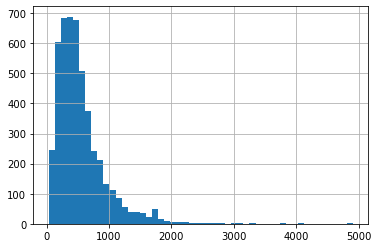

In [110]:
YAAM['seq'].map(len).hist(bins=50)

### Visualize total PTM residues

In [13]:
total_ptm = YAAM['total_ptm'].values
total_residue = YAAM['unique_residues'].values

# plt.hist(total_ptm,bins=30)
# plt.hist(total_residue,bins=30)
# plt.show()

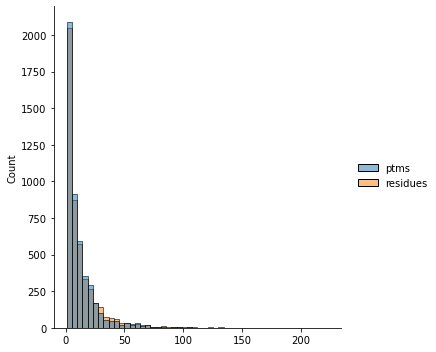

In [14]:
sns.displot({'ptms':total_ptm,
 'residues':total_residue},
           kind='hist',
           bins=50,
           alpha=.5)

### Save the dataframe in PICKLE file for later use

In [260]:
YAAM.head()

,orf_id,residues,total_ptm,len,label,seq
0,YDR148C,14,14,463,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MLSRATRTAAAKSLVKSKVARNVMAASFVKRHASTSLFKQANKVES...
1,YIL037C,1,1,656,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MNNVHIIKPLSLPQRFFSCIFHPLLLIFFTSVILTIWGSFSVIDIT...
2,YPL195W,30,30,932,0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTSLYAPGAEDIRQRLRPFGFFFEKSLKDLIKGIRSHNETPEKLDQ...
3,YDL194W,15,15,884,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MDPNSNSSSETLRQEKQGFLDKALQRVKGIALRRNNSNKDHTTDDT...
4,YNL331C,1,1,376,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTDLFKPLPEPPTELGRLRVLSKTAGIRVSPLILGGASIGDAWSGF...


In [261]:
YAAM.to_csv('./data/YAAM.csv')

In [263]:
pd.read_csv('./data/YAAM.csv')

,Unnamed: 0,orf_id,residues,total_ptm,len,label,seq
0,0,YDR148C,14,14,463,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MLSRATRTAAAKSLVKSKVARNVMAASFVKRHASTSLFKQANKVES...
1,1,YIL037C,1,1,656,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MNNVHIIKPLSLPQRFFSCIFHPLLLIFFTSVILTIWGSFSVIDIT...
2,2,YPL195W,30,30,932,0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTSLYAPGAEDIRQRLRPFGFFFEKSLKDLIKGIRSHNETPEKLDQ...
3,3,YDL194W,15,15,884,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MDPNSNSSSETLRQEKQGFLDKALQRVKGIALRRNNSNKDHTTDDT...
4,4,YNL331C,1,1,376,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MTDLFKPLPEPPTELGRLRVLSKTAGIRVSPLILGGASIGDAWSGF...
...,...,...,...,...,...,...,...
4868,4868,YNL309W,25,25,420,0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MSQPQMSPEKEQELASKILHRAELAQMTRQLKLGLSNVPSTKRKQD...
4869,4869,YLR356W,5,5,197,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MSVCLAITKGIAVSSIGLYSGLLASASLITSTTPLEVLTGSLTPTL...
4870,4870,YDL006W,11,11,281,0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 ...,MSNHSEILERPETPYDITYRVGVAENKNSKFRRTMEDVHTYVKNFA...
4871,4871,YIL109C,16,16,926,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,MSHHKKRVYPQAQLQYGQNATPLQQPAQFMPPQDPAAAGMSYGQMG...
